In [14]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
import yfinance as yf
import random
import matplotlib.pyplot as plt
from collections import deque


[*********************100%***********************]  1 of 1 completed


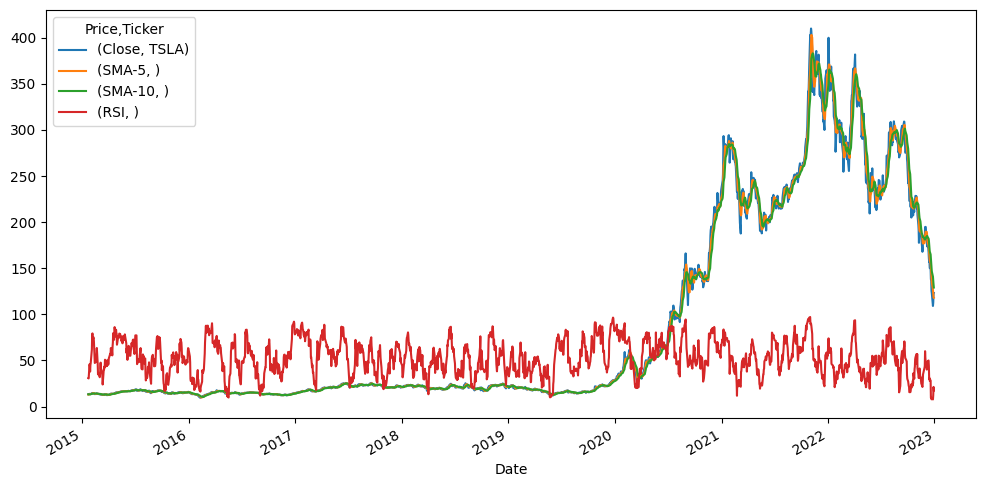

In [15]:
# Download Tesla stock data from Yahoo Finance
stock_data = yf.download('TSLA', start='2015-01-01', end='2023-01-01')

# Calculate the Simple Moving Averages (SMA)
stock_data['SMA-5'] = stock_data['Close'].rolling(window=5).mean()
stock_data['SMA-10'] = stock_data['Close'].rolling(window=10).mean()

# Calculate the Relative Strength Index (RSI)
delta = stock_data['Close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
stock_data['RSI'] = 100 - (100 / (1 + rs))

# Drop NaN values resulting from rolling operations
stock_data = stock_data.dropna()

# Visualize the data
stock_data[['Close', 'SMA-5', 'SMA-10', 'RSI']].plot(figsize=(12, 6))
plt.show()


In [16]:
class QNetwork(tf.keras.Model):
    def __init__(self, action_space):
        super(QNetwork, self).__init__()
        self.dense1 = layers.Dense(64, activation='relu')
        self.dense2 = layers.Dense(64, activation='relu')
        self.q_values = layers.Dense(action_space, activation='linear')  # Output Q-values for each action

    def call(self, state):
        x = self.dense1(state)
        x = self.dense2(x)
        return self.q_values(x)


In [17]:
class ReplayBuffer:
    def __init__(self, buffer_size, batch_size):
        self.buffer = deque(maxlen=buffer_size)
        self.batch_size = batch_size

    def store(self, experience):
        self.buffer.append(experience)

    def sample(self):
        return random.sample(self.buffer, self.batch_size)

    def size(self):
        return len(self.buffer)


In [18]:
# Parameters
action_space = 3  # Buy, Hold, Sell
state_size = 4    # ['Close', 'SMA-5', 'SMA-10', 'RSI']
buffer_size = 10000
batch_size = 32
learning_rate = 0.001
gamma = 0.99      # Discount factor
epsilon = 1.0     # Initial epsilon for exploration
epsilon_min = 0.01
epsilon_decay = 0.995
episodes = 100

# Initialize Q-network, target network, and replay buffer
q_network = QNetwork(action_space)
target_network = QNetwork(action_space)
target_network.set_weights(q_network.get_weights())  # Sync target network

optimizer = tf.keras.optimizers.Adam(learning_rate)
loss_fn = tf.keras.losses.MeanSquaredError()

replay_buffer = ReplayBuffer(buffer_size, batch_size)

# Epsilon-greedy policy
def select_action(state, epsilon):
    if np.random.rand() <= epsilon:
        return np.random.randint(action_space)  # Random action
    q_values = q_network(np.expand_dims(state, axis=0))  # Predict Q-values
    return np.argmax(q_values.numpy())  # Action with highest Q-value

# Training loop
for episode in range(episodes):
    state = stock_data.iloc[0][['Close', 'SMA-5', 'SMA-10', 'RSI']].values
    total_reward = 0

    for t in range(len(stock_data) - 1):
        # Select action
        action = select_action(state, epsilon)

        # Simulate environment response
        next_state = stock_data.iloc[t + 1][['Close', 'SMA-5', 'SMA-10', 'RSI']].values
        reward = next_state[0] - state[0]  # Reward is the price change (simple)
        reward = reward if action == 0 else -reward  # Positive reward for correct action

        done = t == len(stock_data) - 2
        total_reward += reward

        # Store experience in replay buffer
        replay_buffer.store((state, action, reward, next_state, done))
        state = next_state

        # Update the Q-network if replay buffer has enough samples
        if replay_buffer.size() >= batch_size:
            # Sample a batch of experiences
            batch = replay_buffer.sample()
            states, actions, rewards, next_states, dones = map(np.array, zip(*batch))

            # Compute target Q-values
            target_q_values = target_network(next_states)
            targets = rewards + gamma * np.max(target_q_values.numpy(), axis=1) * (1 - dones)

            # Update Q-network
            with tf.GradientTape() as tape:
                q_values = q_network(states)
                q_values = tf.reduce_sum(q_values * tf.one_hot(actions, action_space), axis=1)
                loss = loss_fn(targets, q_values)

            grads = tape.gradient(loss, q_network.trainable_variables)
            optimizer.apply_gradients(zip(grads, q_network.trainable_variables))

        # Update target network periodically
        if t % 10 == 0:
            target_network.set_weights(q_network.get_weights())

        if done:
            break

    # Decay epsilon
    epsilon = max(epsilon_min, epsilon * epsilon_decay)

    print(f"Episode {episode + 1}/{episodes}, Total Reward: {total_reward:.2f}, Epsilon: {epsilon:.3f}")

print("Training complete!")


Episode 1/100, Total Reward: 129.48, Epsilon: 0.995
Episode 2/100, Total Reward: -38.59, Epsilon: 0.990
Episode 3/100, Total Reward: 76.07, Epsilon: 0.985
Episode 4/100, Total Reward: -79.52, Epsilon: 0.980
Episode 5/100, Total Reward: -411.30, Epsilon: 0.975
Episode 6/100, Total Reward: 171.20, Epsilon: 0.970
Episode 7/100, Total Reward: 128.89, Epsilon: 0.966
Episode 8/100, Total Reward: 60.75, Epsilon: 0.961
Episode 9/100, Total Reward: -243.35, Epsilon: 0.956
Episode 10/100, Total Reward: 179.86, Epsilon: 0.951
Episode 11/100, Total Reward: -282.77, Epsilon: 0.946
Episode 12/100, Total Reward: 79.28, Epsilon: 0.942
Episode 13/100, Total Reward: -105.10, Epsilon: 0.937
Episode 14/100, Total Reward: -297.90, Epsilon: 0.932
Episode 15/100, Total Reward: -333.45, Epsilon: 0.928
Episode 16/100, Total Reward: 13.25, Epsilon: 0.923
Episode 17/100, Total Reward: 159.24, Epsilon: 0.918
Episode 18/100, Total Reward: -147.29, Epsilon: 0.914
Episode 19/100, Total Reward: 245.90, Epsilon: 0.909

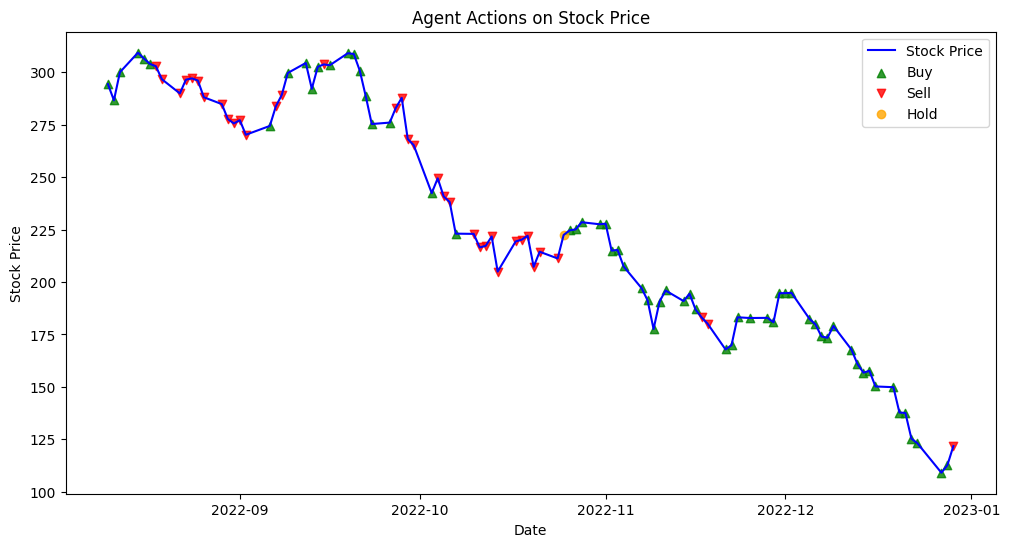

In [20]:
# Test the agent and collect actions
test_data = stock_data.iloc[-100:]  # Use the last 100 rows as test data
state = test_data.iloc[0][['Close', 'SMA-5', 'SMA-10', 'RSI']].values

actions = []  # To store actions
prices = []   # To store stock prices
timestamps = test_data.index  # Dates for plotting

for t in range(len(test_data) - 1):
    action = select_action(state, epsilon=0.01)  # Use low epsilon for exploitation
    actions.append(action)
    prices.append(state[0])  # Save the price for plotting
    state = test_data.iloc[t + 1][['Close', 'SMA-5', 'SMA-10', 'RSI']].values

# Convert actions to markers for visualization
actions = np.array(actions)
buy_signals = np.where(actions == 0)[0]  # Indexes where the agent decided to Buy
sell_signals = np.where(actions == 2)[0]  # Indexes where the agent decided to Sell
hold_signals = np.where(actions == 1)[0]  # Indexes where the agent decided to Hold

# Plot stock prices and agent's actions
plt.figure(figsize=(12, 6))
plt.plot(timestamps[:-1], prices, label='Stock Price', color='blue')

# Add markers for actions
plt.scatter(timestamps[:-1][buy_signals], np.array(prices)[buy_signals],
            label='Buy', marker='^', color='green', alpha=0.8)
plt.scatter(timestamps[:-1][sell_signals], np.array(prices)[sell_signals],
            label='Sell', marker='v', color='red', alpha=0.8)
plt.scatter(timestamps[:-1][hold_signals], np.array(prices)[hold_signals],
            label='Hold', marker='o', color='orange', alpha=0.8)

# Add legend and labels
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Agent Actions on Stock Price')
plt.legend()
plt.show()


Initial Investment: $100000.00
Final Balance: $4786576.54
Profit: $4686576.54


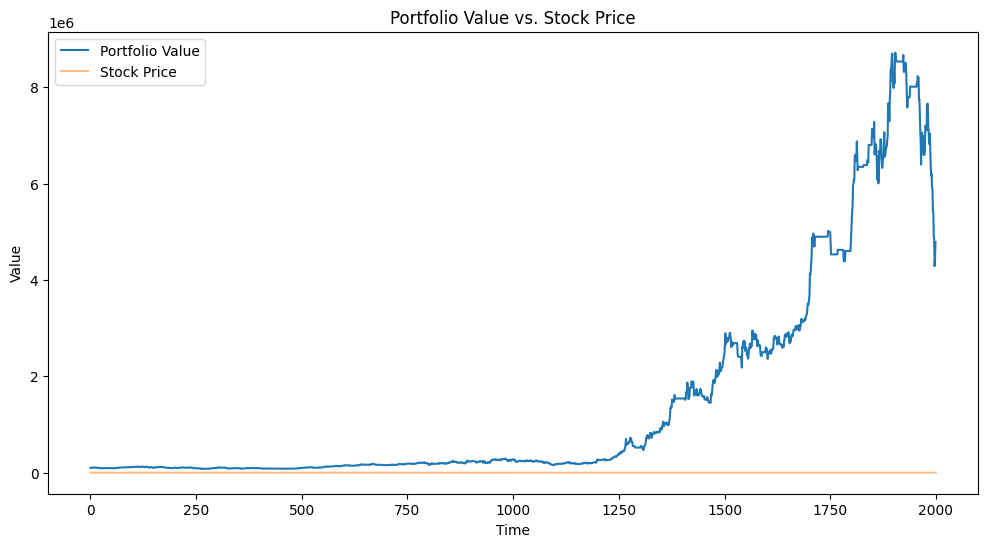

In [30]:
# Parameters for portfolio evaluation
initial_balance = 100000  # Initial investment amount
balance = initial_balance
shares = 0  # Number of shares owned
portfolio_value = []  # Track portfolio value over time

# Simulate the agent's actions
for t in range(len(stock_data) - 1):
    # Get the state and the agent's action
    state = stock_data.iloc[t][['Close', 'SMA-5', 'SMA-10', 'RSI']].values
    action = select_action(state, epsilon=0)  # Use greedy policy (epsilon=0)

    # Get the current stock price (ensure it's a scalar)
    close_price = stock_data.iloc[t]['Close'].item()  # .item() ensures scalar value

    # Perform the chosen action
    if action == 0:  # Buy
        if balance > close_price:  # Ensure there is enough balance
            shares_to_buy = int(balance // close_price)  # Calculate shares to buy
            balance -= shares_to_buy * close_price
            shares += shares_to_buy
    elif action == 2:  # Sell
        if shares > 0:
            balance += shares * close_price  # Sell all shares
            shares = 0

    # Track portfolio value (balance + current value of shares owned)
    portfolio_value.append(balance + shares * close_price)

# Calculate final balance and profit
final_balance = balance + shares * stock_data.iloc[-1]['Close'].item()
profit = final_balance - initial_balance

# Print results
print(f"Initial Investment: ${initial_balance:.2f}")
print(f"Final Balance: ${final_balance:.2f}")
print(f"Profit: ${profit:.2f}")

# Plot portfolio value over time
plt.figure(figsize=(12, 6))
plt.plot(portfolio_value, label='Portfolio Value')
plt.plot(stock_data['Close'].values, label='Stock Price', alpha=0.5)
plt.title('Portfolio Value vs. Stock Price')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()


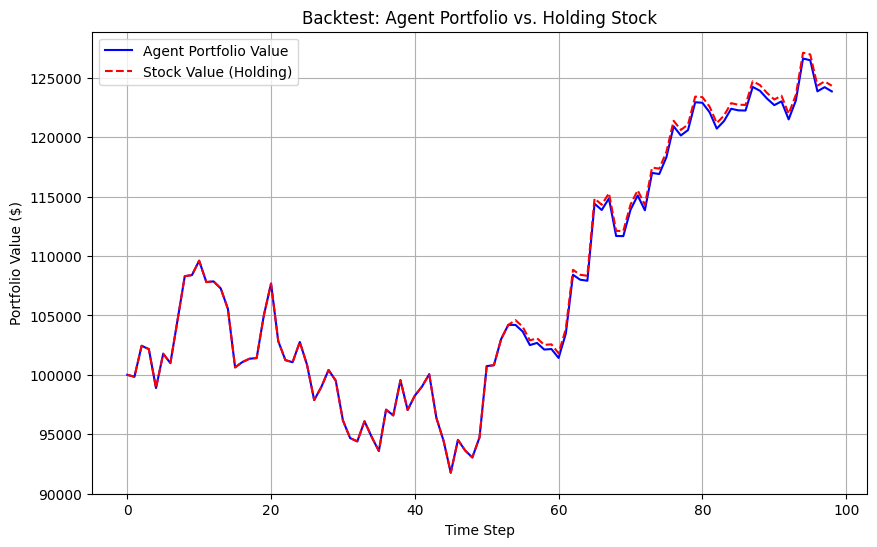

Final Portfolio Value (Agent's Strategy): $123859.47
Final Stock Value (Holding the Stock): $124337.87
Profit from Agent's Strategy: $23859.47
Profit from Holding the Stock: $24337.87


In [34]:
# Assuming 'stock_data' is the historical stock data with a 'Close' column
# and 'actions' is the list of actions taken by the agent (0: Buy, 1: Sell)

# Ensure the 'actions' list is of the same length as stock_data or slice accordingly
num_steps = min(len(stock_data), len(actions))

# Initialize variables for backtesting
initial_balance = 100000  # Initial balance in dollars
balance = initial_balance
shares = 0
initial_investment = initial_balance
portfolio_value = []  # Portfolio value over time
stock_value = []  # Stock value if we just hold the stock

# Loop through the stock data to track portfolio and stock performance
for t in range(num_steps):
    close_price = float(stock_data.iloc[t]['Close'].values[0])  # Get the close price for this time step

    # Backtesting agent's actions
    action = actions[t]  # Action taken by the agent at time step t

    # Agent's trading strategy: buy or sell
    if action == 0:  # Buy
        if balance > close_price:  # Ensure there is enough balance to buy at least one share
            shares_to_buy = int(balance // close_price)  # Calculate shares to buy
            balance -= shares_to_buy * close_price  # Deduct the cost from balance
            shares += shares_to_buy  # Increase number of shares owned
    elif action == 1:  # Sell
        if shares > 0:  # Ensure there are shares to sell
            balance += shares * close_price  # Sell all shares and add the proceeds to balance
            shares = 0  # Reset shares to 0 after selling

    # Track portfolio value (balance + value of owned shares)
    portfolio_value.append(balance + shares * close_price)

    # Track stock value if the agent just held the stock (buying at the start and selling at each time step)
    stock_value.append(initial_investment * (close_price / stock_data.iloc[0]['Close']))  # Value if holding stock from the start

# Convert portfolio_value and stock_value to numpy arrays for comparison
portfolio_value = np.array(portfolio_value)
stock_value = np.array(stock_value)

# Plot the comparison between agent's portfolio and holding the stock
plt.figure(figsize=(10, 6))
plt.plot(portfolio_value, label='Agent Portfolio Value', color='blue')
plt.plot(stock_value, label='Stock Value (Holding)', color='red', linestyle='--')
plt.title('Backtest: Agent Portfolio vs. Holding Stock')
plt.xlabel('Time Step')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.grid(True)
plt.show()

# Calculate final performance metrics
final_agent_value = portfolio_value[-1]
final_stock_value = stock_value[-1].item()  # Extract scalar value from the numpy array
print(f"Final Portfolio Value (Agent's Strategy): ${final_agent_value:.2f}")
print(f"Final Stock Value (Holding the Stock): ${final_stock_value:.2f}")
print(f"Profit from Agent's Strategy: ${final_agent_value - initial_balance:.2f}")
print(f"Profit from Holding the Stock: ${final_stock_value - initial_investment:.2f}")

